In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.font_manager as font_manager
from pathlib import Path


def ecef_to_geodetic(x, y, z):
    a = 6378137.0
    f = 1 / 298.257223563
    b = a * (1 - f)
    e_sq = 1 - (b**2 / a**2)
    ep_sq = (a**2 - b**2) / b**2
    lon = np.degrees(np.arctan2(y, x))
    p = np.sqrt(x**2 + y**2)
    q = np.arctan2((z * a), (p * b))
    lat = np.degrees(np.arctan2(
        (z + ep_sq * b * np.sin(q)**3),
        (p - e_sq * a * np.cos(q)**3)
    ))
    return lat, lon

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def perform_position_estimation(satellite_positions, pseudoranges, satellite_elevations_deg):
    # Need at least 4 satellites
    if len(satellite_positions) < 4:
        return np.array([np.nan, np.nan, np.nan])

    # --- Elevation-based WLS weighting (matching preprocessing script) ---
    elevation_deg = np.array(satellite_elevations_deg, dtype=float).copy()
    min_elevation_deg = 20.0
    elevation_deg[elevation_deg < min_elevation_deg] = min_elevation_deg
    elevation_rad = np.radians(elevation_deg)

    # Weight is sin(elevation). SciPy expects sqrt(weight) in the residuals.
    sqrt_weights = np.sqrt(np.sin(elevation_rad))

    # State: [x, y, z, clock_bias_m]
    x0 = np.array([0.0, 0.0, 0.0, 0.0], dtype=float)

    def residuals_func(x):
        receiver_pos, clock_bias_m = x[:3], x[3]
        distances = np.linalg.norm(satellite_positions - receiver_pos, axis=1)

        # Unweighted residuals: model - measurement
        # model: distance + clock_bias, measurement: pseudoranges
        unweighted_residuals = distances + clock_bias_m - pseudoranges

        # Apply sqrt of W (as in the preprocessing WLS)
        return unweighted_residuals * sqrt_weights

    try:
        res = least_squares(residuals_func, x0)
        return res.x[:3]  # Return only receiver ECEF position
    except Exception:
        return np.array([np.nan, np.nan, np.nan])


def evaluate_model_accuracy(satellite_positions, gt_position_ecef, pseudoranges, correction_residuals, atmospheric_corrections, satellite_elevations_deg):
    corrected_pseudoranges = pseudoranges - correction_residuals
    
    # Pass elevations down to the estimation function
    estimated_position_ecef = perform_position_estimation(
        satellite_positions, 
        corrected_pseudoranges, 
        satellite_elevations_deg  # <-- Pass elevations here
    )
    
    if np.isnan(estimated_position_ecef).any():
        return np.nan
    
    lat_gt, lon_gt = ecef_to_geodetic(gt_position_ecef[0], gt_position_ecef[1], gt_position_ecef[2])
    lat_est, lon_est = ecef_to_geodetic(estimated_position_ecef[0], estimated_position_ecef[1], estimated_position_ecef[2])
    horizontal_error = haversine_distance(lat_gt, lon_gt, lat_est, lon_est)
    return horizontal_error

# =========================================================================
# Helper
# =========================================================================
def get_ecdf_data(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# =========================================================================
# Generalized Plotting for N models
# =========================================================================
def plot_results_multi(
    errors_uncorrected,
    errors_by_model,                # dict[label] -> list[float]
    aggregate_stats,                # dict with 'uncorrected' and labels
    ts_uncorrected,                 # list[(time_ms, err)]
    ts_by_model                     # dict[label] -> list[(time_ms, err)]
):
    sns.set_theme(style="whitegrid")
    try:
        font_path = font_manager.findfont(font_manager.FontProperties(family="Times New Roman"))
        times_new_roman_font = font_manager.FontProperties(fname=font_path, size=14)
    except:
        print("Times New Roman not found, falling back to serif.")
        times_new_roman_font = font_manager.FontProperties(family="serif", size=14)

    # Colors: baseline red, models cycle defaults
    import itertools
    model_labels = list(errors_by_model.keys())
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5']))
    model_colors = {label: next(color_cycle) for label in model_labels}
    baseline_color = 'red'

    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    # --- Histogram
    ax1.hist(errors_uncorrected, bins=50, alpha=0.6, color=baseline_color, label='Uncorrected WLS', density=True)
    for label in model_labels:
        ax1.hist(errors_by_model[label], bins=50, alpha=0.5, color=model_colors[label], label=label, density=True)

    ax1.axvline(x=aggregate_stats['uncorrected']['mean'], color=baseline_color, linestyle='--', lw=2,
                label=f"Mean Uncorrected: {aggregate_stats['uncorrected']['mean']:.2f}m")
    for label in model_labels:
        ax1.axvline(x=aggregate_stats[label]['mean'], color=model_colors[label], linestyle='--', lw=2,
                    label=f"Mean {label}: {aggregate_stats[label]['mean']:.2f}m")

    ax1.set_title('Error Distribution Comparison', fontproperties=times_new_roman_font, fontsize=16)
    ax1.set_xlabel('Horizontal Error (meters)', fontproperties=times_new_roman_font)
    ax1.set_ylabel('Density', fontproperties=times_new_roman_font)
    ax1.set_xlim(left=0)

    # --- ECDF
    x_unc, y_unc = get_ecdf_data(errors_uncorrected)
    ax2.plot(x_unc, y_unc, label=f"Uncorrected WLS (P95={aggregate_stats['uncorrected']['p95']:.1f}m)",
             linewidth=2, color=baseline_color)

    max_error = np.max(errors_uncorrected) if len(errors_uncorrected) else 0.0
    for label in model_labels:
        x_m, y_m = get_ecdf_data(errors_by_model[label])
        ax2.plot(x_m, y_m, label=f"{label} (P95={aggregate_stats[label]['p95']:.1f}m)",
                 linewidth=2, color=model_colors[label])
        if len(x_m):
            max_error = max(max_error, np.max(x_m))

    if len(x_unc):
        ax2.hlines(y=1.0, xmin=x_unc[-1], xmax=max_error, color=baseline_color, linewidth=2)
    for label in model_labels:
        x_m, _ = get_ecdf_data(errors_by_model[label])
        if len(x_m):
            ax2.hlines(y=1.0, xmin=x_m[-1], xmax=max_error, color=model_colors[label], linewidth=2)

    ax2.set_title('Cumulative Distribution of Errors (ECDF)', fontproperties=times_new_roman_font, fontsize=16)
    ax2.set_xlabel('Horizontal Error (meters)', fontproperties=times_new_roman_font)
    ax2.set_ylabel('Cumulative Probability', fontproperties=times_new_roman_font)
    ax2.set_xlim(left=0, right=max_error if max_error > 0 else None)
    ax2.set_ylim([0, 1.05])

    # --- Time Series
    if len(ts_uncorrected):
        times_unc, errs_unc = zip(*ts_uncorrected)
        times_unc = np.array(times_unc) / 1000.0
        t0 = np.min(times_unc)
        times_unc -= t0
        ax3.plot(times_unc, errs_unc, label='Uncorrected WLS', linewidth=1.5, color=baseline_color, alpha=0.8)
        ax3.axhline(y=aggregate_stats['uncorrected']['mean'], color=baseline_color, linestyle='--', lw=1.5, alpha=0.5)

    for label in model_labels:
        series = ts_by_model[label]
        if not len(series):
            continue
        times_m, errs_m = zip(*series)
        times_m = np.array(times_m) / 1000.0
        # Normalize to same t0 as baseline if available; else local
        if len(ts_uncorrected):
            t0 = np.min(np.array([t for t,_ in ts_uncorrected])) / 1000.0
            times_m -= t0
        else:
            times_m -= np.min(times_m)
        ax3.plot(times_m, errs_m, label=label, linewidth=1.5, color=model_colors[label], alpha=0.8)
        ax3.axhline(y=aggregate_stats[label]['mean'], color=model_colors[label], linestyle='--', lw=1.5, alpha=0.5)

    ax3.set_title('Horizontal Error Over Time', fontproperties=times_new_roman_font, fontsize=16)
    ax3.set_xlabel('Time (seconds)', fontproperties=times_new_roman_font)
    ax3.set_ylabel('Horizontal Error (meters)', fontproperties=times_new_roman_font)
    ax3.set_xlim(left=0)
    ax3.set_ylim(bottom=0)

    # --- Formatting
    for ax in [ax1, ax2, ax3]:
        ax.grid(True, which='both', linestyle='--', color='grey', alpha=0.5)
        ax.legend(prop=times_new_roman_font, frameon=True, edgecolor="black", framealpha=0.95)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color("black")
        ax.tick_params(axis="both", which="major", length=6, width=1.5)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(times_new_roman_font)

    plt.tight_layout()
    plt.savefig("gnss_error_analysis_plots_with_timeseries.png", dpi=300, bbox_inches='tight')
    plt.show()

# =========================================================================
# Main Evaluation (generalized to N correction files)
# =========================================================================

def evaluate_with_position_matching_multi(
    data_directory,                 # list[str] of satellite CSVs
    correction_files,               # list[str] of correction CSVs
    ground_truth_dir,               # list[str] of GT CSVs
    train_ratio=0.75,
    model_labels=None               # optional list[str]; same length as correction_files
):
    """
    Evaluate performance for an arbitrary number of correction files.

    Each correction CSV is expected to have columns:
        ['x','Time_ms','Satellite_ID','Real_PR_res','Predicted_PR_res']
    """
    # ---- Load corrections
    print("--- DEBUG: Loading correction files ---")
    corr_colnames = ['x', 'Time_ms', 'Satellite_ID', 'Real_PR_res', 'Predicted_PR_res']
    corr_dfs = []
    pred_cols = []
    if model_labels is None:
        model_labels = [Path(f).stem for f in correction_files]
    else:
        assert len(model_labels) == len(correction_files), "model_labels must match correction_files length"

    for idx, f in enumerate(correction_files):
        df_corr = pd.read_csv(f, names=corr_colnames).drop(columns=['x'])
        df_corr.rename(columns={'Satellite_ID': 'Sat_ID',
                                'Predicted_PR_res': f'Predicted_PR_res_{idx}'}, inplace=True)
        corr_dfs.append(df_corr)
        pred_cols.append(f'Predicted_PR_res_{idx}')
        print(f"Loaded {len(df_corr)} correction rows from '{model_labels[idx]}'")

    # ---- Load sat/GT data
    sat_files = data_directory
    gt_files = ground_truth_dir
    if not sat_files or not gt_files:
        print("Error: No files found in specified directories. Please check paths.")
        return

    print(f"Found {len(sat_files)} satellite files and {len(gt_files)} ground truth files")
    all_sat_test_dfs, all_gt_test_dfs = [], []

    print("\n--- DEBUG: Processing satellite and ground truth files ---")
    for sat_file, gt_file in zip(sat_files, gt_files):
        print(f"Processing satellite file: {os.path.basename(sat_file)}")
        sat_cols = ['Time_ms', 'Sat_ID', 'Sat_Pos_X', 'Sat_Pos_Y', 'Sat_Pos_Z', 'P-Range Group A', 'Atmospheric_Correction', 'Elevation']
        df_sat_full = pd.read_csv(sat_file, usecols=sat_cols)
        n_rows = len(df_sat_full)
        split_idx = int(n_rows * train_ratio)
        df_sat_test = df_sat_full.iloc[split_idx:].copy()
        all_sat_test_dfs.append(df_sat_test)

        print(f"  - Full satellite data shape: {df_sat_full.shape}")
        print(f"  - Train/Test split ratio: {train_ratio*100:.1f}% / {(1-train_ratio)*100:.1f}%")
        print(f"  - Calculated initial test split shape: {df_sat_test.shape}")

        df_gt_full = pd.read_csv(gt_file, skiprows=1)[['Time_ms', 'Pos_X', 'Pos_Y', 'Pos_Z']]
        test_timestamps = df_sat_test['Time_ms'].unique()
        df_gt_test = df_gt_full[df_gt_full['Time_ms'].isin(test_timestamps)]
        all_gt_test_dfs.append(df_gt_test)

    df_sat_all_test = pd.concat(all_sat_test_dfs, ignore_index=True)
    df_gt_all_test = pd.concat(all_gt_test_dfs, ignore_index=True).drop_duplicates(subset=['Time_ms'])

    print("\n--- DEBUG: Final size check before merging ---")
    print(f"Total EXPECTED test rows from all sat files: {len(df_sat_all_test)}")

    # ---- Optional truncation to match min corrections size (keeps alignment if your corrections were generated 1:1)
    min_corr_len = min(len(df) for df in corr_dfs)
    if len(df_sat_all_test) > min_corr_len:
        print(f"\n*** Size Mismatch Detected ***")
        print(f"Truncating test set from {len(df_sat_all_test)} to {min_corr_len} rows to match correction files.")
        df_sat_all_test = df_sat_all_test.iloc[:min_corr_len].copy()
        print(f"  - New test set shape: {df_sat_all_test.shape}")

    # ---- Merge sat with GT
    df_merged = pd.merge(df_sat_all_test, df_gt_all_test, on='Time_ms', how='inner')

    # ---- Merge each correction DF
    df_eval = df_merged.copy()
    for idx, df_corr in enumerate(corr_dfs):
        df_eval = pd.merge(df_eval, df_corr[['Time_ms', 'Sat_ID', pred_cols[idx]]],
                           on=['Time_ms', 'Sat_ID'], how='left')

    # Fill missing corrections with 0 for each model column
    df_eval.fillna({col: 0 for col in pred_cols}, inplace=True)
    
#     # remove final bits
#     df_eval = df_eval[df_eval['Time_ms']<12500000]

    # ---- Iterate timestamps
    unique_timestamps = df_eval['Time_ms'].unique()
    ts_uncorrected = []
    ts_by_model = {label: [] for label in model_labels}

    errors_uncorrected = []
    errors_by_model = {label: [] for label in model_labels}

    for time_ms in tqdm(unique_timestamps, desc="Calculating Positions"):
        epoch = df_eval[df_eval['Time_ms'] == time_ms]
        if len(epoch) < 4:
            continue

        epoch = epoch.sort_values(by='Sat_ID')
        sat_positions = epoch[['Sat_Pos_X', 'Sat_Pos_Y', 'Sat_Pos_Z']].values
        gt_position = epoch[['Pos_X', 'Pos_Y', 'Pos_Z']].iloc[0].values
        pseudoranges = epoch['P-Range Group A'].values - epoch['Atmospheric_Correction'].values
        atmospheric_corrections = epoch['Atmospheric_Correction'].values
        satellite_elevations = epoch['Elevation'].values

        # Baseline
        err_unc = evaluate_model_accuracy(sat_positions, gt_position, pseudoranges,
                                          np.zeros_like(pseudoranges), atmospheric_corrections,
                                          satellite_elevations)
        if np.isnan(err_unc):
            continue
        ts_uncorrected.append((time_ms, err_unc))
        errors_uncorrected.append(err_unc)

        # Each model
        for idx, label in enumerate(model_labels):
            pr_res = epoch[pred_cols[idx]].values
            err_m = evaluate_model_accuracy(sat_positions, gt_position, pseudoranges, pr_res, 
                                            atmospheric_corrections, 
                                            satellite_elevations)
            if not np.isnan(err_m):
                ts_by_model[label].append((time_ms, err_m))
                errors_by_model[label].append(err_m)

    if not errors_uncorrected:
        print("No valid errors calculated. Check data alignment and inputs.")
        return

    # ---- Aggregate stats
    aggregate_stats = {
        'uncorrected': {
            'mean': float(np.mean(errors_uncorrected)),
            'p50': float(np.percentile(errors_uncorrected, 50)),
            'p95': float(np.percentile(errors_uncorrected, 95))
        }
    }
    for label in model_labels:
        vals = np.array(errors_by_model[label])
        if len(vals) == 0:
            aggregate_stats[label] = {'mean': np.nan, 'p50': np.nan, 'p95': np.nan}
        else:
            aggregate_stats[label] = {
                'mean': float(np.mean(vals)),
                'p50': float(np.percentile(vals, 50)),
                'p95': float(np.percentile(vals, 95))
            }

    print("\n" + "=" * 60)
    print("AGGREGATE RESULTS")
    print("=" * 60)
    print("\nUNCORRECTED (Baseline):")
    print(f"  Mean Error:     {aggregate_stats['uncorrected']['mean']:.4f} m")
    print(f"  Median (P50):   {aggregate_stats['uncorrected']['p50']:.4f} m")
    print(f"  P95 Error:      {aggregate_stats['uncorrected']['p95']:.4f} m")

    for label in model_labels:
        print(f"\n{label} CORRECTED:")
        print(f"  Mean Error:     {aggregate_stats[label]['mean']:.4f} m" if not np.isnan(aggregate_stats[label]['mean']) else "  Mean Error:     NaN")
        print(f"  Median (P50):   {aggregate_stats[label]['p50']:.4f} m" if not np.isnan(aggregate_stats[label]['p50']) else "  Median (P50):   NaN")
        print(f"  P95 Error:      {aggregate_stats[label]['p95']:.4f} m" if not np.isnan(aggregate_stats[label]['p95']) else "  P95 Error:      NaN")

    # ---- Plot
    plot_results_multi(errors_uncorrected, errors_by_model, aggregate_stats, ts_uncorrected, ts_by_model)

    return aggregate_stats



GNSS Model Evaluation - 75/25 Split (Multi-model)
--- DEBUG: Loading correction files ---
Loaded 48008 correction rows from 'results_transformer_v1_5Jan_highway'
Found 1 satellite files and 1 ground truth files

--- DEBUG: Processing satellite and ground truth files ---
Processing satellite file: sat_data_V1A1_5Jan_highway_multipath_processed.csv
  - Full satellite data shape: (48008, 8)
  - Train/Test split ratio: 0.0% / 100.0%
  - Calculated initial test split shape: (48008, 8)

--- DEBUG: Final size check before merging ---
Total EXPECTED test rows from all sat files: 48008


Calculating Positions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6001/6001 [00:41<00:00, 146.00it/s]
/tmp/ipykernel_170853/130829276.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



AGGREGATE RESULTS

UNCORRECTED (Baseline):
  Mean Error:     13.5840 m
  Median (P50):   12.8955 m
  P95 Error:      25.4875 m

results_transformer_v1_5Jan_highway CORRECTED:
  Mean Error:     8.5796 m
  Median (P50):   7.6765 m
  P95 Error:      20.5481 m


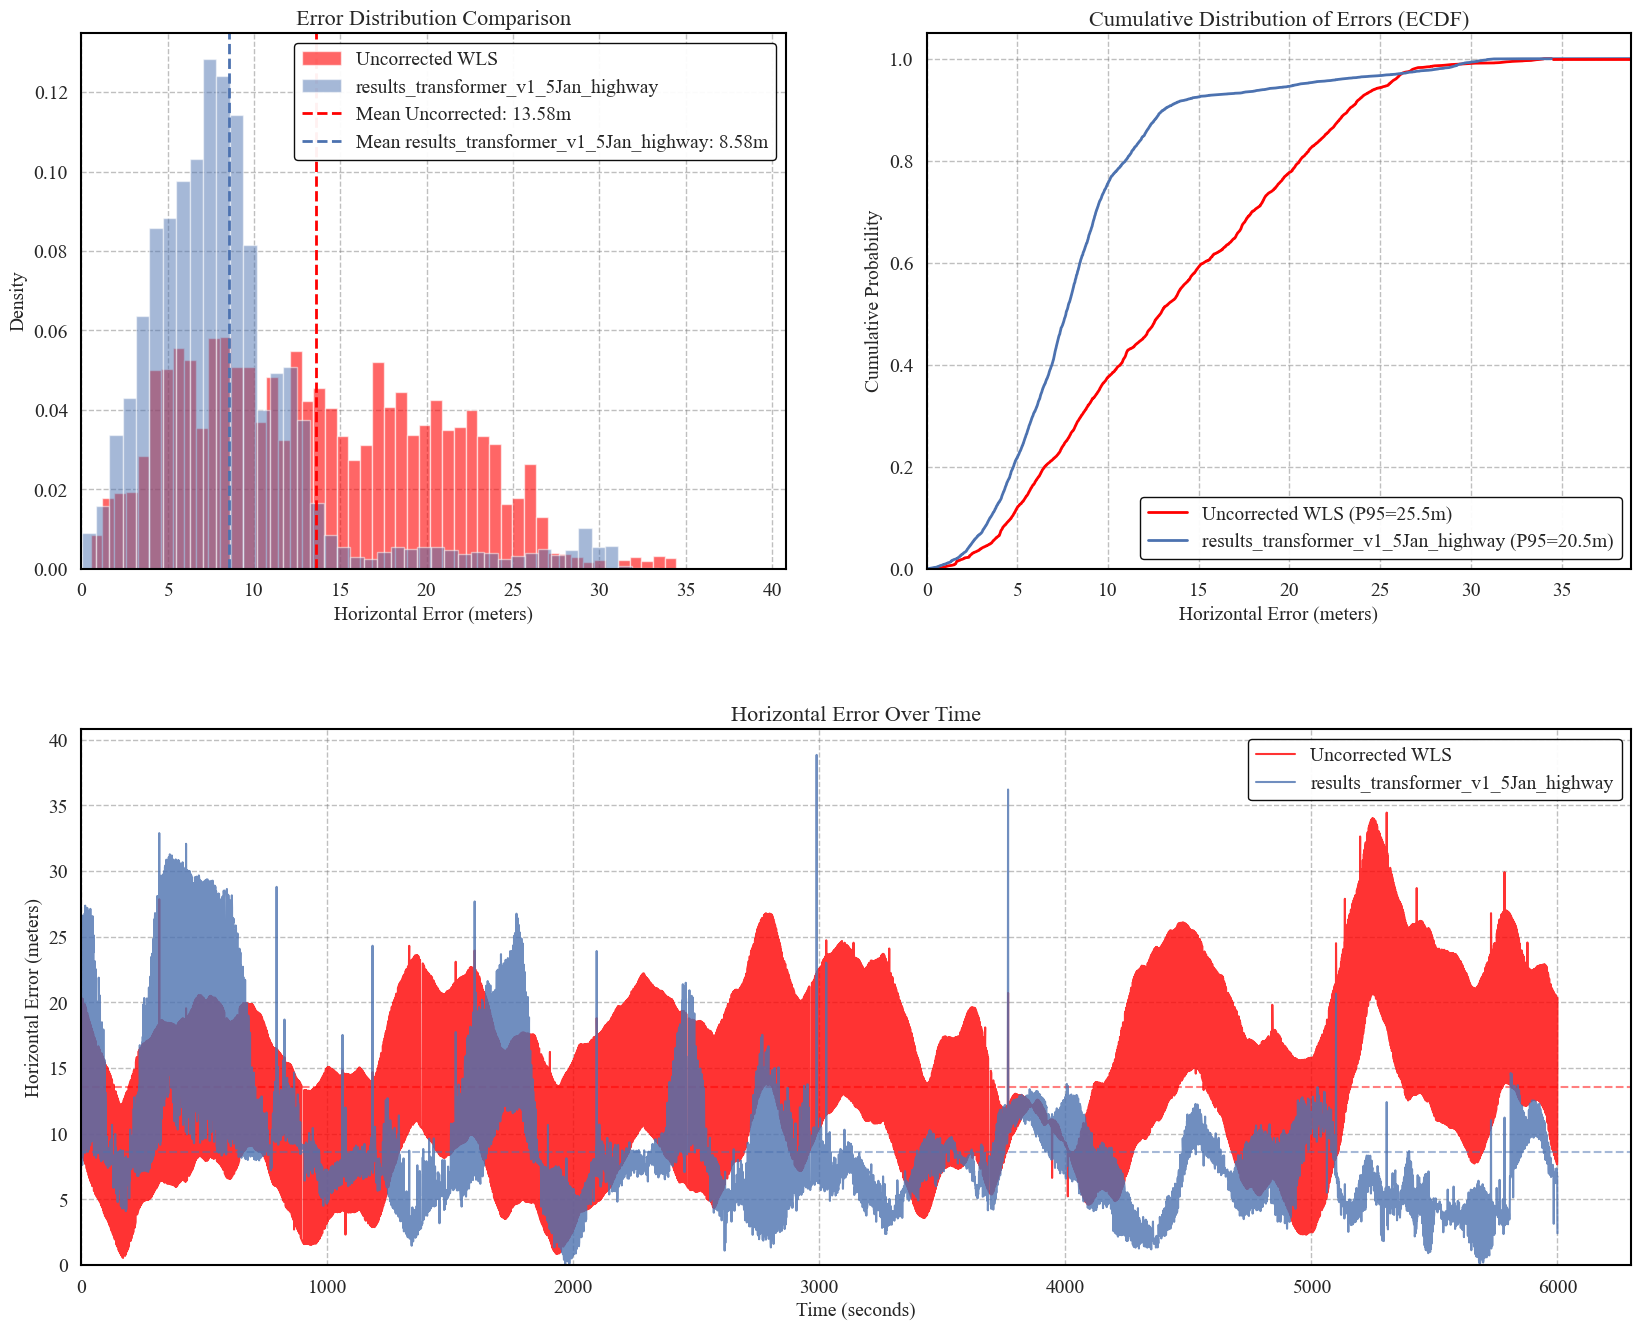

In [6]:

if __name__ == '__main__':
    print("=" * 60)
    print("GNSS Model Evaluation - 75/25 Split (Multi-model)")
    print("=" * 60)

    aggregate_stats = evaluate_with_position_matching_multi(
        data_directory=[
        "/home/fermino/Downloads/PR_Correction/simGNSS/data/data_v1/sat_data_V1A1_5Jan_highway_multipath_processed.csv"
        ],
        correction_files=[
        '/home/fermino/Downloads/PR_Correction/simGNSS/results_transformer_v1_5Jan_highway.csv',
        ],
        ground_truth_dir=[
        "/home/fermino/Downloads/PR_Correction/simGNSS/data/ground_truth/motion_V1_5Jan_highway_multipath.csv"
        ],
        train_ratio=0.00,
    )


GNSS Model Evaluation - 75/25 Split (Multi-model)
--- DEBUG: Loading correction files ---
Loaded 54009 correction rows from 'results_transformer_v1_5Jan_suburban'
Found 1 satellite files and 1 ground truth files

--- DEBUG: Processing satellite and ground truth files ---
Processing satellite file: sat_data_V1A1_5Jan_suburban_multipath_processed.csv
  - Full satellite data shape: (54009, 8)
  - Train/Test split ratio: 0.0% / 100.0%
  - Calculated initial test split shape: (54009, 8)

--- DEBUG: Final size check before merging ---
Total EXPECTED test rows from all sat files: 54009


Calculating Positions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6001/6001 [00:40<00:00, 146.99it/s]
/tmp/ipykernel_170853/130829276.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



AGGREGATE RESULTS

UNCORRECTED (Baseline):
  Mean Error:     11.3436 m
  Median (P50):   10.9701 m
  P95 Error:      19.2634 m

results_transformer_v1_5Jan_suburban CORRECTED:
  Mean Error:     7.2524 m
  Median (P50):   7.2298 m
  P95 Error:      12.6997 m


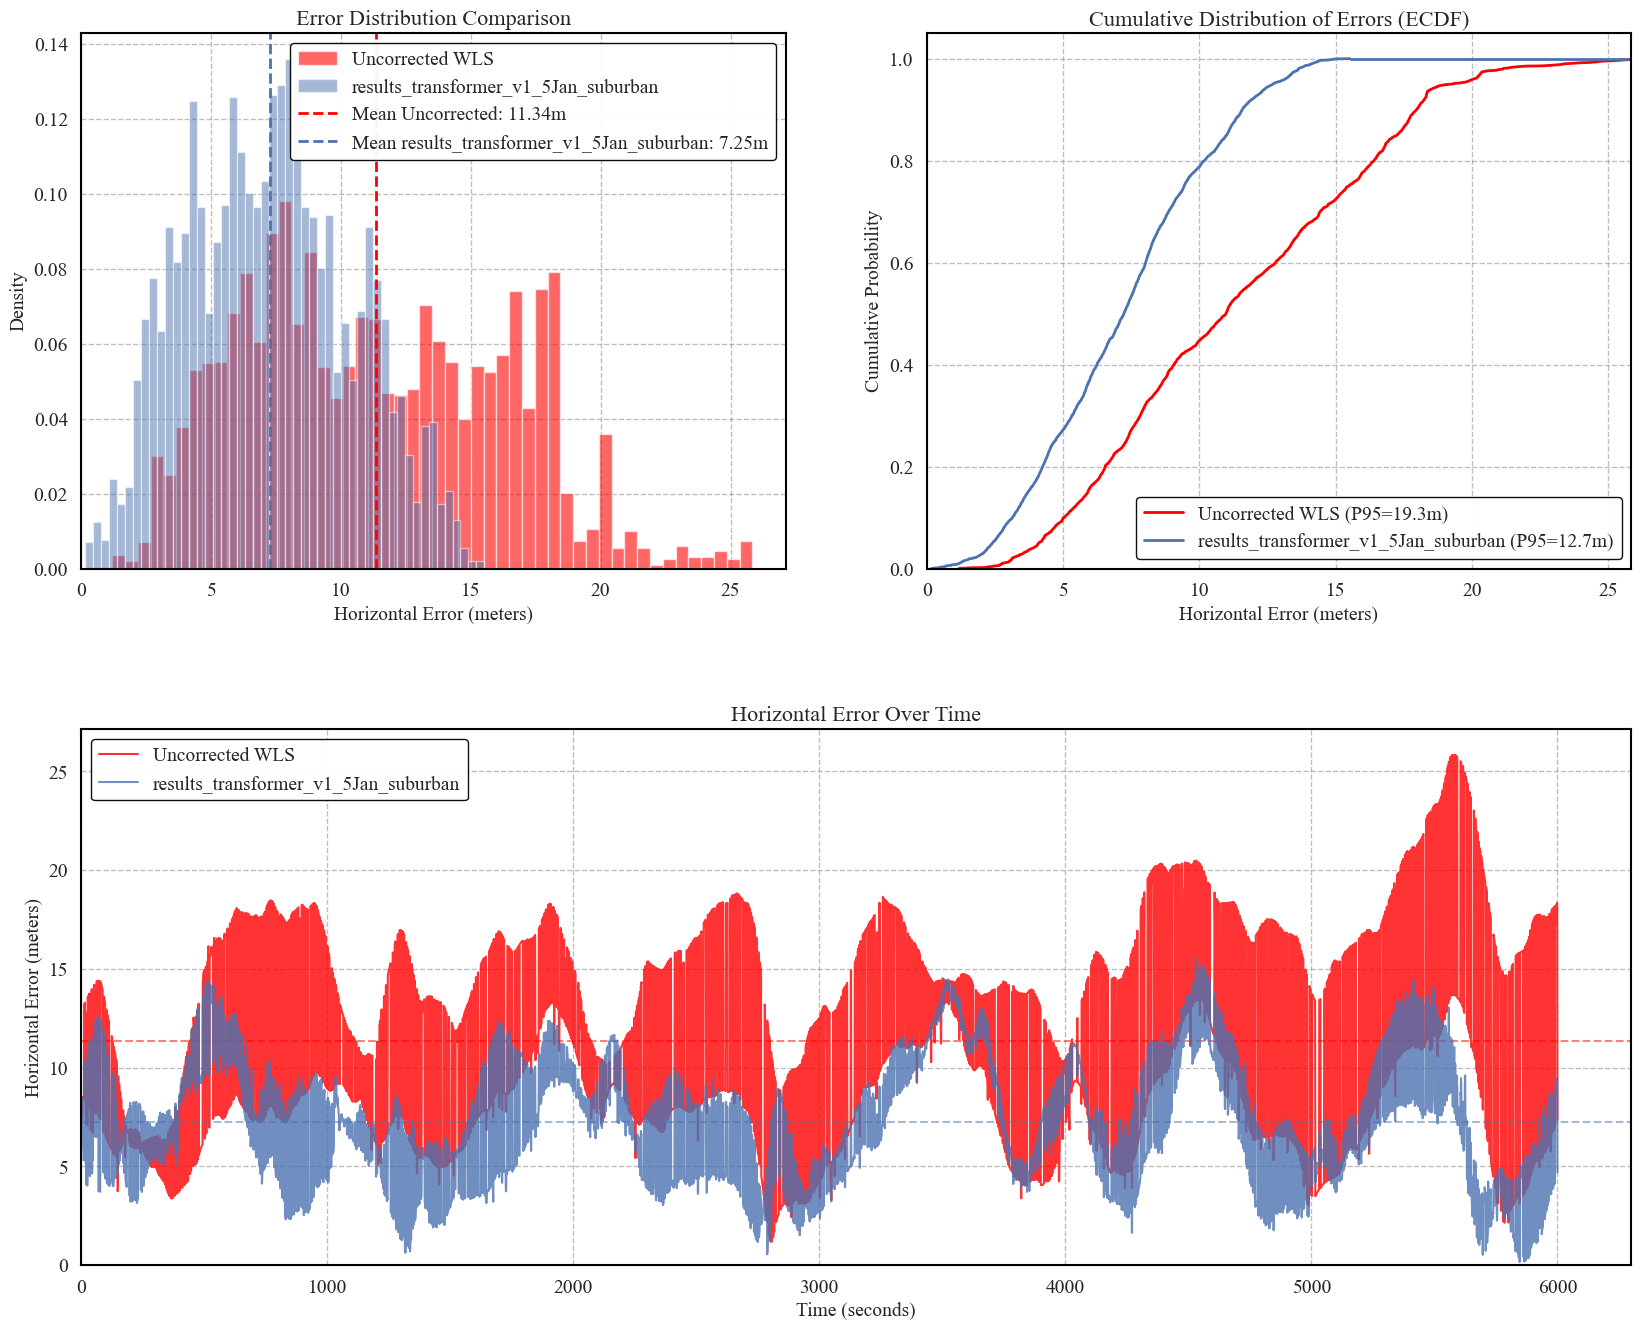

In [7]:

if __name__ == '__main__':
    print("=" * 60)
    print("GNSS Model Evaluation - 75/25 Split (Multi-model)")
    print("=" * 60)

    aggregate_stats = evaluate_with_position_matching_multi(
        data_directory=[
        "/home/fermino/Downloads/PR_Correction/simGNSS/data/data_v1/sat_data_V1A1_5Jan_suburban_multipath_processed.csv"
        ],
        correction_files=[
        '/home/fermino/Downloads/PR_Correction/simGNSS/results_transformer_v1_5Jan_suburban.csv',
        ],
        ground_truth_dir=[
        "/home/fermino/Downloads/PR_Correction/simGNSS/data/ground_truth/motion_V1_5Jan_suburban_multipath.csv"
        ],
        train_ratio=0.00,
    )


In [ ]:
8/13